# Импорт

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from LookGenerator.datasets.utils import load_image
from LookGenerator.datasets.person_segmentation_dataset import PersonSegmentationDataset, PersonSegmentationDatasetMultichannel
from LookGenerator.networks.segmentation import UNet
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks.losses import FocalLossMulti
from LookGenerator.networks.utils import load_model
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks_training.utils import check_path_and_creat

# Загрузка данных

In [2]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
    transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

transform_output = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0),
    custom_transforms.MinMaxScale(),
    custom_transforms.ThresholdTransform(threshold=0.5)
])

In [3]:
batch_size_train = 96
batch_size_val = 64
pin_memory = True
num_workers = 12

In [4]:
train_dataset = PersonSegmentationDatasetMultichannel(r'C:\Users\DenisovDmitrii\Desktop\12channels\trainData',
    #r"C:\Users\DenisovDmitrii\Desktop\trainData",
                                                      transform_input=transform_input,
                                                      transform_output=transform_output)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
(len(train_dataset), len(train_dataloader))

(11647, 122)

In [5]:
val_dataset = PersonSegmentationDatasetMultichannel(r'C:\Users\DenisovDmitrii\Desktop\12channels\valData',
    #r"C:\Users\DenisovDmitrii\Desktop\trainData",
                                                      transform_input=transform_input,
                                                      transform_output=transform_output
                                                    )#r"C:\Users\DenisovDmitrii\Desktop\valData")
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)
(len(val_dataset), len(val_dataloader))

(2032, 32)

Test load train_dataloader. and val.

torch.Size([96, 3, 256, 192])
torch.Size([96, 12, 256, 192])
False


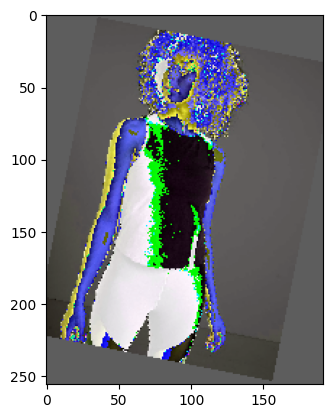

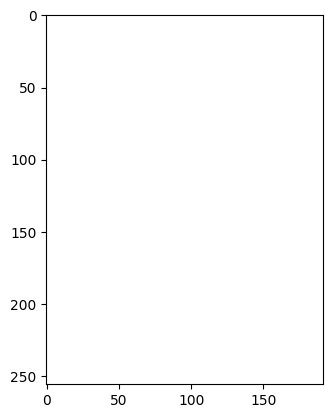

In [6]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    print(X.requires_grad)
    X = transforms.ToPILImage() (X[0])
    X = np.array(X)
    plt.imshow(X)
    plt.show()
    y = transforms.ToPILImage()(y[0,11])
    y = np.array(y)
    plt.imshow(y, cmap='binary')
    plt.show()

    break

# Обучение модели

torch.Size([64, 3, 256, 192])
torch.Size([64, 12, 256, 192])
False


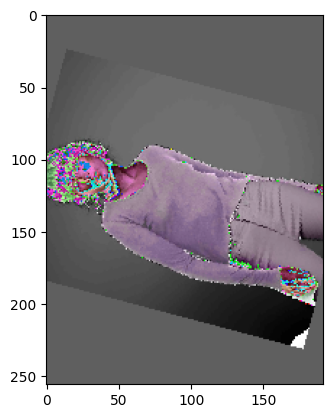

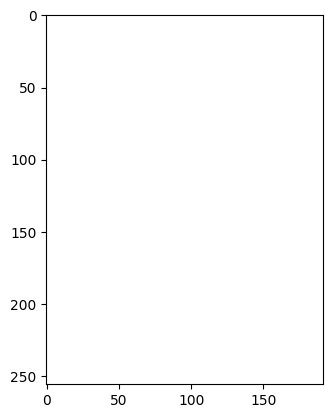

In [7]:
for X, y in val_dataloader:
    print(X.shape)
    print(y.shape)
    print(X.requires_grad)
    X = transforms.ToPILImage() (X[0])
    X = np.array(X)
    plt.imshow(X)
    plt.show()
    y = transforms.ToPILImage()(y[0,11])
    y = np.array(y)
    plt.imshow(y, cmap='binary')
    plt.show()

    break

Метки классов на изображении:

1. Левое лицо                       248,251,14
2. Правое лицо                      251,235,25
3. Туловище                         20,80,194
4. Внешняя верхняя левая рука       190,189,96
5. Внешняя верхняя правая рука      215,187,88
6. Внешняя нижняя левая рука        252,206,48
7. Внешняя нижняя правая рука       250,220,36
8. Внутренняя верхняя левая рука    145,191,116
9. Внутренняя верхняя правая рука   170,190,105
10. Внетренняя нижняя левая рука     228,191,74
11. Внутренняя нижняя правая рука    240,198,60
12. Левая кисть                      8,110,221
13. Правая кисть                     4,98,224
14. Левая нога                       22,173,184
15. Правая нога                      6,166,198

In [8]:
model = UNet(in_channels=3, out_channels = 12, features=(16, 32, 64, 128, 256, 512))
#model = load_model(model, r'C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmentationMulty\weights\testMulty_out_11\epoch_29.pt')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = FocalLossMulti(device=device)
print(device)

cuda


In [9]:
save_directory = r'C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmentationMulty\weights\testMulty_out_12_6features'
check_path_and_creat(save_directory)

True

In [10]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [11]:
trainer = Trainer(
    model_=model, optimizer=optimizer, criterion=criterion,
    device=device, save_directory=save_directory, save_step=1, verbose=True
)

In [12]:
epoch_num=30

In [13]:
trainer.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch_num=epoch_num)

start time 02-06-2023 11:11


100%|██████████| 122/122 [03:35<00:00,  1.77s/it]


Epoch 0 of 29, train loss: 0.00258
Epoch end time 02-06-2023 11:15


100%|██████████| 32/32 [00:38<00:00,  1.19s/it]


Epoch 0 of 29, val loss: 0.00163
Epoch end time 02-06-2023 11:15


100%|██████████| 122/122 [03:30<00:00,  1.72s/it]


Epoch 1 of 29, train loss: 0.00080
Epoch end time 02-06-2023 11:19


100%|██████████| 32/32 [00:36<00:00,  1.15s/it]


Epoch 1 of 29, val loss: 0.00075
Epoch end time 02-06-2023 11:19


100%|██████████| 122/122 [03:28<00:00,  1.71s/it]


Epoch 2 of 29, train loss: 0.00046
Epoch end time 02-06-2023 11:23


100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


Epoch 2 of 29, val loss: 0.00040
Epoch end time 02-06-2023 11:23


100%|██████████| 122/122 [03:29<00:00,  1.72s/it]


Epoch 3 of 29, train loss: 0.00036
Epoch end time 02-06-2023 11:27


100%|██████████| 32/32 [00:36<00:00,  1.16s/it]


Epoch 3 of 29, val loss: 0.00038
Epoch end time 02-06-2023 11:28


100%|██████████| 122/122 [03:28<00:00,  1.71s/it]


Epoch 4 of 29, train loss: 0.00032
Epoch end time 02-06-2023 11:31


100%|██████████| 32/32 [00:36<00:00,  1.14s/it]


Epoch 4 of 29, val loss: 0.00024
Epoch end time 02-06-2023 11:32


100%|██████████| 122/122 [03:26<00:00,  1.69s/it]


Epoch 5 of 29, train loss: 0.00026
Epoch end time 02-06-2023 11:35


100%|██████████| 32/32 [00:36<00:00,  1.15s/it]


Epoch 5 of 29, val loss: 0.00025
Epoch end time 02-06-2023 11:36


100%|██████████| 122/122 [03:26<00:00,  1.69s/it]


Epoch 6 of 29, train loss: 0.00020
Epoch end time 02-06-2023 11:39


100%|██████████| 32/32 [00:36<00:00,  1.15s/it]


Epoch 6 of 29, val loss: 0.00019
Epoch end time 02-06-2023 11:40


100%|██████████| 122/122 [03:28<00:00,  1.71s/it]


Epoch 7 of 29, train loss: 0.00016
Epoch end time 02-06-2023 11:43


100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


Epoch 7 of 29, val loss: 0.00017
Epoch end time 02-06-2023 11:44


100%|██████████| 122/122 [03:27<00:00,  1.70s/it]


Epoch 8 of 29, train loss: 0.00015
Epoch end time 02-06-2023 11:47


100%|██████████| 32/32 [00:36<00:00,  1.14s/it]


Epoch 8 of 29, val loss: 0.00016
Epoch end time 02-06-2023 11:48


100%|██████████| 122/122 [03:30<00:00,  1.73s/it]


Epoch 9 of 29, train loss: 0.00015
Epoch end time 02-06-2023 11:51


100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


Epoch 9 of 29, val loss: 0.00014
Epoch end time 02-06-2023 11:52


100%|██████████| 122/122 [03:31<00:00,  1.73s/it]


Epoch 10 of 29, train loss: 0.00016
Epoch end time 02-06-2023 11:56


100%|██████████| 32/32 [00:37<00:00,  1.19s/it]


Epoch 10 of 29, val loss: 0.00014
Epoch end time 02-06-2023 11:56


100%|██████████| 122/122 [03:34<00:00,  1.76s/it]


Epoch 11 of 29, train loss: 0.00013
Epoch end time 02-06-2023 12:00


100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


Epoch 11 of 29, val loss: 0.00014
Epoch end time 02-06-2023 12:00


100%|██████████| 122/122 [03:32<00:00,  1.74s/it]


Epoch 12 of 29, train loss: 0.00019
Epoch end time 02-06-2023 12:04


100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


Epoch 12 of 29, val loss: 0.00032
Epoch end time 02-06-2023 12:05


100%|██████████| 122/122 [03:37<00:00,  1.78s/it]


Epoch 13 of 29, train loss: 0.00012
Epoch end time 02-06-2023 12:08


100%|██████████| 32/32 [00:36<00:00,  1.15s/it]


Epoch 13 of 29, val loss: 0.00012
Epoch end time 02-06-2023 12:09


100%|██████████| 122/122 [03:28<00:00,  1.71s/it]


Epoch 14 of 29, train loss: 0.00011
Epoch end time 02-06-2023 12:12


100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


Epoch 14 of 29, val loss: 0.00010
Epoch end time 02-06-2023 12:13


100%|██████████| 122/122 [03:22<00:00,  1.66s/it]


Epoch 15 of 29, train loss: 0.00011
Epoch end time 02-06-2023 12:16


100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


Epoch 15 of 29, val loss: 0.00010
Epoch end time 02-06-2023 12:17


100%|██████████| 122/122 [03:28<00:00,  1.71s/it]


Epoch 16 of 29, train loss: 0.00010
Epoch end time 02-06-2023 12:20


100%|██████████| 32/32 [00:36<00:00,  1.16s/it]


Epoch 16 of 29, val loss: 0.00011
Epoch end time 02-06-2023 12:21


100%|██████████| 122/122 [03:28<00:00,  1.71s/it]


Epoch 17 of 29, train loss: 0.00010
Epoch end time 02-06-2023 12:24


100%|██████████| 32/32 [00:36<00:00,  1.15s/it]


Epoch 17 of 29, val loss: 0.00011
Epoch end time 02-06-2023 12:25


100%|██████████| 122/122 [03:29<00:00,  1.71s/it]


Epoch 18 of 29, train loss: 0.00010
Epoch end time 02-06-2023 12:29


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch 18 of 29, val loss: 0.00010
Epoch end time 02-06-2023 12:29


100%|██████████| 122/122 [03:33<00:00,  1.75s/it]


Epoch 19 of 29, train loss: 0.00010
Epoch end time 02-06-2023 12:33


100%|██████████| 32/32 [00:37<00:00,  1.16s/it]


Epoch 19 of 29, val loss: 0.00010
Epoch end time 02-06-2023 12:33


100%|██████████| 122/122 [03:34<00:00,  1.76s/it]


Epoch 20 of 29, train loss: 0.00009
Epoch end time 02-06-2023 12:37


100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


Epoch 20 of 29, val loss: 0.00009
Epoch end time 02-06-2023 12:38


100%|██████████| 122/122 [03:34<00:00,  1.76s/it]


Epoch 21 of 29, train loss: 0.00008
Epoch end time 02-06-2023 12:41


100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


Epoch 21 of 29, val loss: 0.00010
Epoch end time 02-06-2023 12:42


100%|██████████| 122/122 [03:34<00:00,  1.76s/it]


Epoch 22 of 29, train loss: 0.00009
Epoch end time 02-06-2023 12:45


100%|██████████| 32/32 [00:45<00:00,  1.42s/it]


Epoch 22 of 29, val loss: 0.00009
Epoch end time 02-06-2023 12:46


100%|██████████| 122/122 [03:47<00:00,  1.86s/it]


Epoch 23 of 29, train loss: 0.00009
Epoch end time 02-06-2023 12:50


100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


Epoch 23 of 29, val loss: 0.00010
Epoch end time 02-06-2023 12:51


100%|██████████| 122/122 [03:33<00:00,  1.75s/it]


Epoch 24 of 29, train loss: 0.00010
Epoch end time 02-06-2023 12:54


100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


Epoch 24 of 29, val loss: 0.00011
Epoch end time 02-06-2023 12:55


100%|██████████| 122/122 [03:31<00:00,  1.73s/it]


Epoch 25 of 29, train loss: 0.00008
Epoch end time 02-06-2023 12:58


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epoch 25 of 29, val loss: 0.00008
Epoch end time 02-06-2023 12:59


100%|██████████| 122/122 [03:31<00:00,  1.73s/it]


Epoch 26 of 29, train loss: 0.00008
Epoch end time 02-06-2023 13:02


100%|██████████| 32/32 [00:37<00:00,  1.16s/it]


Epoch 26 of 29, val loss: 0.00008
Epoch end time 02-06-2023 13:03


100%|██████████| 122/122 [03:33<00:00,  1.75s/it]


Epoch 27 of 29, train loss: 0.00008
Epoch end time 02-06-2023 13:07


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch 27 of 29, val loss: 0.00008
Epoch end time 02-06-2023 13:07


100%|██████████| 122/122 [03:37<00:00,  1.78s/it]


Epoch 28 of 29, train loss: 0.00007
Epoch end time 02-06-2023 13:11


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epoch 28 of 29, val loss: 0.00008
Epoch end time 02-06-2023 13:12


100%|██████████| 122/122 [03:33<00:00,  1.75s/it]


Epoch 29 of 29, train loss: 0.00007
Epoch end time 02-06-2023 13:15


100%|██████████| 32/32 [00:38<00:00,  1.19s/it]

Epoch 29 of 29, val loss: 0.00008
Epoch end time 02-06-2023 13:16
end time 02-06-2023 13:16
delta 2:04:44.256617


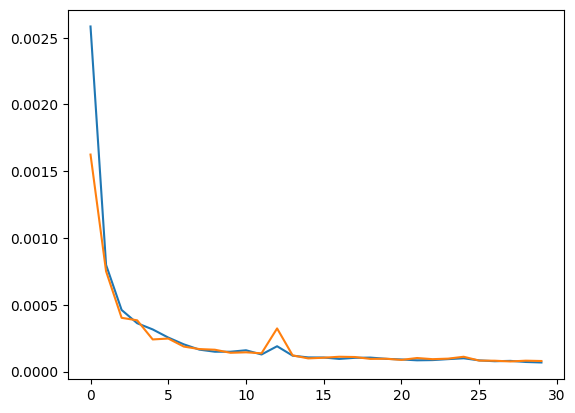

In [14]:
trainer.draw_history_plots()

In [17]:
from torchsummary import summary
summary(model.to('cuda'), (3, 256, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 192]           1,792
       BatchNorm2d-2         [-1, 64, 256, 192]             128
         LeakyReLU-3         [-1, 64, 256, 192]               0
         LeakyReLU-4         [-1, 64, 256, 192]               0
           Conv3x3-5         [-1, 64, 256, 192]               0
            Conv2d-6         [-1, 64, 256, 192]          36,928
       BatchNorm2d-7         [-1, 64, 256, 192]             128
           Conv3x3-8         [-1, 64, 256, 192]               0
         LeakyReLU-9         [-1, 64, 256, 192]               0
        LeakyReLU-10         [-1, 64, 256, 192]               0
          Conv5x5-11         [-1, 64, 256, 192]               0
        MaxPool2d-12          [-1, 64, 128, 96]               0
           Conv2d-13         [-1, 128, 128, 96]          73,856
      BatchNorm2d-14         [-1, 128, 

In [ ]:
model = load_model(model, r'C:\Users\Даша\PycharmProjects\SMBackEnd\LookGenerator\weights\unet_epoch_0_0.0161572862694324.pt')
model.eval()

In [ ]:
test_dir = r""
test_folder = ""
save_masks_dir = r""
list_files = os.listdir(test_dir)
images = [file.split('.') for file in list_files]

In [ ]:
for image in images:
    print(image)
    img = load_image(test_dir, test_folder, image, '.jpg')
    img_to_model = prepare_image_for_model(img, transform_input)
    modelled = model(img_to_model)
    mask = to_array_from_model_bin(modelled)

    plt.figure(figsize=(18, 6))
    plt.subplot(1,2,0)
    plt.imshow(img)
    plt.subplot(1,2,1)
    plt.imshow(mask)

    Image.fromarray(mask, 'L').save(save_masks_dir + image + '.png')
